In [1]:
#@title PyG 실습에 필요한 패키지 설치
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)
print(TORCH)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)
print(CUDA)

!pip install torch-scatter     -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-geometric

1.9.0
cu102
     |████████████████████████████████| 3.0 MB 10.5 MB/s 
     |████████████████████████████████| 1.6 MB 12.4 MB/s 
     |████████████████████████████████| 926 kB 11.2 MB/s 
     |████████████████████████████████| 382 kB 11.1 MB/s 
     |████████████████████████████████| 222 kB 13.6 MB/s 
     |████████████████████████████████| 376 kB 48.3 MB/s 
     |████████████████████████████████| 45 kB 3.3 MB/s 


In [2]:
import os.path as osp

import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.manifold import TSNE
from torch_sparse import SparseTensor
from torch_geometric.nn import Node2Vec
from torch_geometric.datasets import Planetoid
from torch_geometric.utils.num_nodes import maybe_num_nodes

from tqdm.notebook import tqdm

In [3]:
dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(path, dataset)
data = dataset[0]

Processing...
Done!


In [4]:
data

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#### PARAMETERS
- `edge_index (LongTensor)` – The edge indices.

- `embedding_dim (int)` – The size of each embedding vector.

- `walk_length (int)` – The walk length.

- `context_size (int)` – The actual context size which is considered for positive samples. This parameter increases the effective sampling rate by reusing samples across different source nodes.

- `walks_per_node (int, optional)` – The number of walks to sample for each node. (default: 1)

- `p (float, optional)` – Likelihood of immediately revisiting a node in the walk. (default: 1)

- `q (float, optional)` – Control parameter to interpolate between breadth-first strategy and depth-first strategy (default: 1)

- `num_negative_samples (int, optional)` – The number of negative samples to use for each positive sample. (default: 1)

- `num_nodes (int, optional)` – The number of nodes. (default: None)

- `sparse (bool, optional)` – If set to True, gradients w.r.t. to the weight matrix will be sparse. (default: False)

In [6]:
from torch.utils.data import DataLoader

class node2vec(Node2Vec):
    def __inint__(self):
        super(node2vec, self).__inint__()

    def batch_loader(self, **kwargs):
        return DataLoader(range(self.adj.sparse_size(0)),
                          collate_fn=self.get_batch, **kwargs)
        
    def get_batch(self, batch):
        if not isinstance(batch, torch.Tensor):
            batch = torch.tensor(batch)
        return batch

In [7]:
model = node2vec(edge_index=data.edge_index,
                 embedding_dim=128,
                 walk_length=20, # l
                 context_size=10, # k
                 walks_per_node=20, # r
                 num_negative_samples=1,
                 p=200, q=1,
                 sparse=True).to(device)

In [8]:
loader = model.loader(batch_size=128, shuffle=True, num_workers=2)

In [9]:
for idx, (pos_rw, neg_rw) in enumerate(loader):
    print(idx, pos_rw.shape, neg_rw.shape)

0 torch.Size([28160, 10]) torch.Size([28160, 10])
1 torch.Size([28160, 10]) torch.Size([28160, 10])
2 torch.Size([28160, 10]) torch.Size([28160, 10])
3 torch.Size([28160, 10]) torch.Size([28160, 10])
4 torch.Size([28160, 10]) torch.Size([28160, 10])
5 torch.Size([28160, 10]) torch.Size([28160, 10])
6 torch.Size([28160, 10]) torch.Size([28160, 10])
7 torch.Size([28160, 10]) torch.Size([28160, 10])
8 torch.Size([28160, 10]) torch.Size([28160, 10])
9 torch.Size([28160, 10]) torch.Size([28160, 10])
10 torch.Size([28160, 10]) torch.Size([28160, 10])
11 torch.Size([28160, 10]) torch.Size([28160, 10])
12 torch.Size([28160, 10]) torch.Size([28160, 10])
13 torch.Size([28160, 10]) torch.Size([28160, 10])
14 torch.Size([28160, 10]) torch.Size([28160, 10])
15 torch.Size([28160, 10]) torch.Size([28160, 10])
16 torch.Size([28160, 10]) torch.Size([28160, 10])
17 torch.Size([28160, 10]) torch.Size([28160, 10])
18 torch.Size([28160, 10]) torch.Size([28160, 10])
19 torch.Size([28160, 10]) torch.Size([28

In [10]:
(pos_rw, neg_rw) = next(iter(loader))

In [11]:
pos_rw

tensor([[2271, 1441,  241,  ..., 1355, 1171, 1909],
        [1958,  735, 1958,  ...,  454, 1917, 1914],
        [ 320, 1597,  320,  ...,  381,  148,  714],
        ...,
        [ 647, 1360,  904,  ..., 1960, 2491, 1360],
        [1664, 2147, 2146,  ..., 2486, 1684, 2513],
        [ 947,  786,  947,  ...,  786,  947,  786]])

In [12]:
neg_rw

tensor([[2271, 1312, 1687,  ..., 2098, 1101, 1423],
        [1958, 2047,  386,  ..., 2509,  981, 2121],
        [ 320, 1334, 2039,  ..., 2038,  635,  377],
        ...,
        [ 428,  337, 1995,  ..., 2152, 2078, 1299],
        [ 223, 1305, 1005,  ...,  268, 1864,  257],
        [1514, 2064, 1379,  ...,  996,  900, 2521]])

### Positive sample 뽑는 함수
```
    def pos_sample(self, batch):
        batch = batch.repeat(self.walks_per_node{20})
        rowptr, col, _ = self.adj.csr()
        rw = random_walk(rowptr, col, batch, self.walk_length, self.p, self.q)
        if not isinstance(rw, torch.Tensor):
            rw = rw[0]

        walks = []
        num_walks_per_rw = 1 + self.walk_length + 1 - self.context_size
        for j in range(num_walks_per_rw):
            walks.append(rw[:, j:j + self.context_size])
        return torch.cat(walks, dim=0)
```



In [13]:
batch_loader = model.batch_loader(batch_size=128, shuffle=True, num_workers=2)

In [14]:
random_walk = torch.ops.torch_cluster.random_walk

In [15]:
print(data.edge_index)
N = maybe_num_nodes(data.edge_index, data.num_nodes)
print(N)
row, col = data.edge_index
adj = SparseTensor(row=row, col=col, sparse_sizes=(N, N))
rowptr, col, _ = adj.csr()

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])
2708


#### adj 시작

In [16]:
adj[:20]

SparseTensor(row=tensor([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  2,  2,  3,  4,  4,  4,  4,  4,  5,
                            5,  5,  6,  6,  6,  6,  7,  8,  8,  8,  9,  9, 10, 10, 11, 11, 12, 12,
                           12, 12, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16, 17,
                           17, 17, 17, 17, 18, 18, 18, 18, 18, 19]),
             col=tensor([ 633, 1862, 2582,    2,  652,  654,    1,  332, 1454, 1666, 1986, 2544,
                           1016, 1256, 1761, 2175, 2176, 1629, 1659, 2546,  373, 1042, 1416, 1602,
                            208,  269,  281, 1996,  723, 2614,  476, 2545, 1655, 1839, 1001, 1318,
                           2661, 2662, 1701, 1810,  158, 2034, 2075, 2077, 2668, 1090, 1093, 1271,
                           2367,  970, 1632, 2444, 2642,   24,  927, 1315, 1316, 2140,  139, 1560,
                           1786, 2082, 2145, 1939]),
             size=(20, 2708), nnz=64, density=0.12%)

In [18]:
adj_dense = adj.to_dense()
adj_dense

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

In [19]:
adj_csr = adj.csr()
adj_csr

(tensor([    0,     3,     6,  ..., 10548, 10552, 10556]),
 tensor([ 633, 1862, 2582,  ...,  598, 1473, 2706]),
 None)

In [20]:
print(rowptr)
print(len(rowptr))

tensor([    0,     3,     6,  ..., 10548, 10552, 10556])
2709


In [21]:
print(col)
print(len(col))

tensor([ 633, 1862, 2582,  ...,  598, 1473, 2706])
10556


In [22]:
rowptr[:5]

tensor([ 0,  3,  6, 11, 12])

In [23]:
col[:14]

tensor([ 633, 1862, 2582,    2,  652,  654,    1,  332, 1454, 1666, 1986, 2544,
        1016, 1256])

#### adj 끝

----

In [47]:
batch_pos = next(iter(batch_loader))

In [48]:
print(batch_pos)
print(batch_pos.shape)

tensor([ 144, 1198,  269, 2428, 2311, 2236,  563,  353, 2123, 1567, 1341, 1621,
         910,  358,  335, 1896,  579, 1196,  797, 2383,  106, 1525,  157, 1958,
        1248, 1362,  867, 1714, 1122, 1514, 1210,  241,  932, 2430,  638, 2559,
        2389,  298, 1723,  785, 1931,  599, 1656, 2611,  725, 1225,  834,  762,
         671, 2520, 2532, 2320, 1751,  872, 1957,  889, 1745,  839,  738, 1537,
         943, 1331, 2195,   41, 2340,    9, 1637, 1528,  522,  847, 2160, 2156,
         363,  185, 2328, 1564, 1695,  338,   64, 1203, 2448, 2163, 1367, 1699,
        1872, 1647,  739,  887, 2091, 2084,  792, 1073, 1922, 2392, 2297, 2179,
         520,  917,  868,  490, 2027,  608, 1687,  845, 1578,  123,  973, 1869,
         312, 1548,  609, 1466, 2519,  980, 2129, 1474, 1132, 1942, 1999, 1245,
         637, 1230, 1821, 1767,   59,  493, 2628, 1366])
torch.Size([128])


In [50]:
walk_length = 20 # l
context_size = 10 # k
walks_per_nodes = 10 # r

batch_pos = batch_pos.repeat(walks_per_nodes)
batch_neg = torch.clone(batch_pos)

In [51]:
batch_pos.shape

torch.Size([1280])

In [52]:
# rw code : https://github.com/rusty1s/pytorch_cluster/blob/master/torch_cluster/rw.py
rw = random_walk(rowptr, col, batch_pos, 20, 200, 1)

In [53]:
rw

(tensor([[ 144,  213,  145,  ...,  537, 1593,  213],
         [1198, 1042, 2054,  ...,  997,  183, 1837],
         [ 269,  321,  269,  ..., 1986,  179, 1986],
         ...,
         [ 493,  391,   68,  ..., 1857, 1701, 1865],
         [2628,   67,  282,  ...,  270, 2280,  242],
         [1366, 1194, 2670,  ..., 1257,  688, 1257]]),
 tensor([[  652,   902,   658,  ...,  4548,  2206,  6294],
         [ 4677,  4056,  8495,  ...,   814,  3863,   815],
         [ 1092,  1349,  1093,  ...,  4267,  8138,   796],
         ...,
         [ 2039,  1587,   259,  ...,  1207,  7557,  6790],
         [10384,   254,  1144,  ...,  9394,  1100,  9393],
         [ 5452,  4665, 10463,  ...,  4710,  4891,  2754]]))

In [54]:
rw = rw[0]

In [55]:
rw.shape

torch.Size([1280, 21])

#### Pos sampling

21 - 10 + 1 => 12

[1280 * 12 , 10]

In [56]:
walks = []
num_walks_per_rw = 1 + walk_length + 1 - context_size
print(rw[0])
for j in range(num_walks_per_rw):
    print(rw[:, j:j + context_size][0])
    walks.append(rw[:, j:j + context_size])
pos_sp = torch.cat(walks, dim=0)

tensor([ 144,  213,  145, 1165,  537, 2192,  144, 1593,  537, 2192,  537, 1593,
        1165,  537,  145,  213, 1593, 1165,  537, 1593,  213])
tensor([ 144,  213,  145, 1165,  537, 2192,  144, 1593,  537, 2192])
tensor([ 213,  145, 1165,  537, 2192,  144, 1593,  537, 2192,  537])
tensor([ 145, 1165,  537, 2192,  144, 1593,  537, 2192,  537, 1593])
tensor([1165,  537, 2192,  144, 1593,  537, 2192,  537, 1593, 1165])
tensor([ 537, 2192,  144, 1593,  537, 2192,  537, 1593, 1165,  537])
tensor([2192,  144, 1593,  537, 2192,  537, 1593, 1165,  537,  145])
tensor([ 144, 1593,  537, 2192,  537, 1593, 1165,  537,  145,  213])
tensor([1593,  537, 2192,  537, 1593, 1165,  537,  145,  213, 1593])
tensor([ 537, 2192,  537, 1593, 1165,  537,  145,  213, 1593, 1165])
tensor([2192,  537, 1593, 1165,  537,  145,  213, 1593, 1165,  537])
tensor([ 537, 1593, 1165,  537,  145,  213, 1593, 1165,  537, 1593])
tensor([1593, 1165,  537,  145,  213, 1593, 1165,  537, 1593,  213])


In [57]:
pos_sp.shape

torch.Size([15360, 10])

#### Negative Sampling

In [58]:
num_negative_samples = 1
# negative sampling에서 시작 노드는 postive sampling에서와 똑같다.
# batch_neg = batch_neg.repeat(walks_per_nodes * num_negative_samples)
print(batch_neg)
print(batch_neg.shape)

tensor([ 144, 1198,  269,  ...,  493, 2628, 1366])
torch.Size([1280])


In [59]:
# node indices에서 rw size만큼 랜덤 샘플링
rw = torch.randint(adj.sparse_size(0),
                    (batch_neg.size(0), walk_length))

In [60]:
rw

tensor([[1992,  267, 1782,  ..., 2466,  622, 1565],
        [1106, 1319, 2329,  ..., 1701,  592, 1194],
        [ 732, 1370,  196,  ...,  729, 1337,  358],
        ...,
        [ 186,  352, 1743,  ...,  765, 2267,  883],
        [1127, 1418, 1825,  ..., 2248, 2482, 2373],
        [ 911,  936, 1944,  ..., 1010,  964,  371]])

In [61]:
batch_neg.shape

torch.Size([1280])

In [62]:
batch_neg.view(-1,1).shape, rw.shape

(torch.Size([1280, 1]), torch.Size([1280, 20]))

In [63]:
rw = torch.cat([batch_neg.view(-1, 1), rw], dim=-1)

In [64]:
rw.shape

torch.Size([1280, 21])

In [65]:
rw

tensor([[ 144, 1992,  267,  ..., 2466,  622, 1565],
        [1198, 1106, 1319,  ..., 1701,  592, 1194],
        [ 269,  732, 1370,  ...,  729, 1337,  358],
        ...,
        [ 493,  186,  352,  ...,  765, 2267,  883],
        [2628, 1127, 1418,  ..., 2248, 2482, 2373],
        [1366,  911,  936,  ..., 1010,  964,  371]])

In [66]:
walks = []
num_walks_per_rw = 1 + walk_length + 1 - context_size
for j in range(num_walks_per_rw):
    walks.append(rw[:, j:j + context_size])
neg_sp = torch.cat(walks, dim=0)

In [67]:
neg_sp

tensor([[ 144, 1992,  267,  ...,  961, 2276, 1386],
        [1198, 1106, 1319,  ..., 2283, 1031, 2247],
        [ 269,  732, 1370,  ..., 2400,   14,  389],
        ...,
        [2175, 2255, 2276,  ...,  765, 2267,  883],
        [1727, 2661, 1786,  ..., 2248, 2482, 2373],
        [ 475,  808,   39,  ..., 1010,  964,  371]])

### Visualization

In [71]:
data.edge_index.numpy().transpose()

array([[   0,  633],
       [   0, 1862],
       [   0, 2582],
       ...,
       [2707,  598],
       [2707, 1473],
       [2707, 2706]])

In [72]:
edge_tuples = [tuple(x) for x in data.edge_index.numpy().transpose()]
G = nx.from_edgelist(edge_tuples)

#### nx에서 layout
https://frhyme.github.io/python-lib/networkx_layout/

In [73]:
pos = nx.spring_layout(G, center=[0.5, 0.5])

In [ ]:
pos[0]

array([0.34300801, 0.6226519 ])

In [75]:
nx.set_node_attributes(G, pos, 'pos')

In [76]:
tmp = next(enumerate(loader))
tmp

(0, (tensor([[1521,   98, 1521,  ...,  408,  347,  423],
          [1813, 1424, 1621,  ...,  794, 1160, 2268],
          [ 140,  623,  140,  ...,  582, 2548,  582],
          ...,
          [2096, 1784, 2096,  ...,  306, 1193,  306],
          [2296, 2230,  938,  ..., 2295, 1655, 1842],
          [2383,  588,  442,  ...,  286,  442, 2362]]),
  tensor([[1521, 1315, 2459,  ..., 2548, 2211, 2267],
          [1813,  589,  228,  ...,  888, 2193, 1089],
          [ 140,  415, 1490,  ..., 1873,  271,  459],
          ...,
          [   9,  860, 2417,  ..., 1009, 1297, 2274],
          [ 707, 1540, 1140,  ..., 2094, 2351, 2620],
          [2118,  560, 2397,  ...,  200, 2024,  508]])))

In [77]:
nodelist = tmp[1][0][0].tolist()

In [78]:
nodelist

[1521, 98, 1521, 1013, 334, 95, 734, 408, 347, 423]

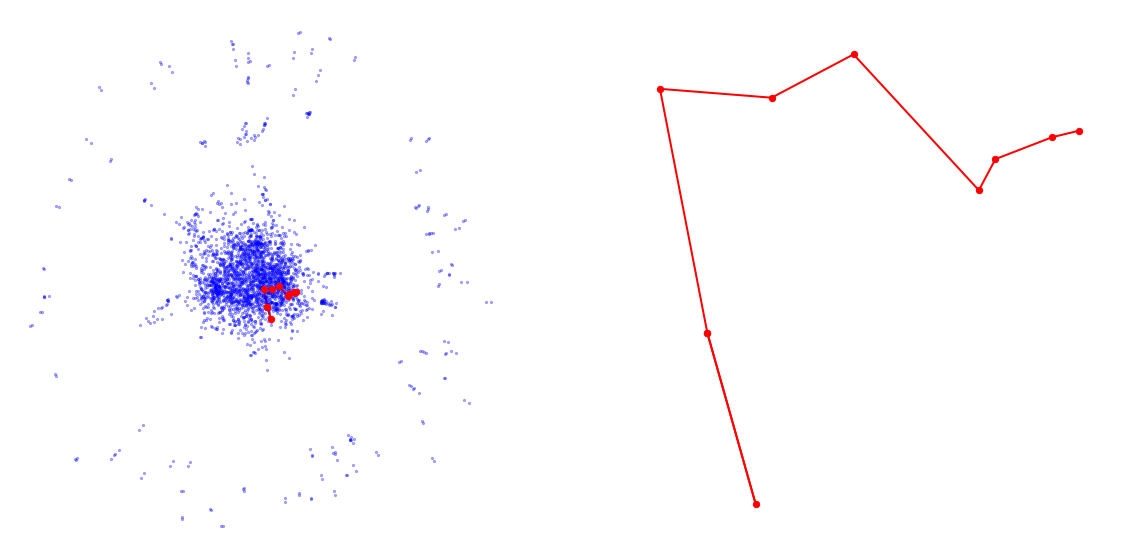

In [79]:
# 임의의 rw path를 path graph로 정의하고,
# node attriburtes로 node index에 대응하는 pos 값을 저장.
walk = nx.path_graph(len(nodelist))
nx.set_node_attributes(walk, {idx: pos[node_id] for idx, node_id in enumerate(nodelist)}, 'pos')

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1)
nx.draw_networkx_nodes(G,
                       ax=ax,
                       pos=nx.get_node_attributes(G,'pos'),
                       node_size = 5,
                       alpha=0.3,
                       node_color='b')

nx.draw(walk,
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'),
        width=2,
        edge_color='r')

ax = fig.add_subplot(1,2,2)
nx.draw(walk,
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'),
        width=2,
        edge_color='r')

### Training

In [92]:
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)
loader = model.loader(batch_size=128, shuffle=True, num_workers=2)
opt = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

In [93]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        opt.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()

        opt.step()

        total_loss += loss.item()
    return total_loss / len(loader)

In [94]:
data.y.unique()

tensor([0, 1, 2, 3, 4, 5, 6])

In [95]:
@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=150)
    return acc

In [96]:
for epoch in tqdm(range(1, 201)):
    loss = train()
    acc = test()
    if (epoch % 10) == 0:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 10, Loss: 1.7345, Acc: 0.4270
Epoch: 20, Loss: 0.9716, Acc: 0.6320
Epoch: 30, Loss: 0.8703, Acc: 0.6760
Epoch: 40, Loss: 0.8447, Acc: 0.7010
Epoch: 50, Loss: 0.8347, Acc: 0.7100
Epoch: 60, Loss: 0.8288, Acc: 0.6990
Epoch: 70, Loss: 0.8261, Acc: 0.7100
Epoch: 80, Loss: 0.8259, Acc: 0.7090
Epoch: 90, Loss: 0.8239, Acc: 0.7000
Epoch: 100, Loss: 0.8234, Acc: 0.7230
Epoch: 110, Loss: 0.8241, Acc: 0.7320
Epoch: 120, Loss: 0.8246, Acc: 0.7090
Epoch: 130, Loss: 0.8243, Acc: 0.7070
Epoch: 140, Loss: 0.8238, Acc: 0.7070
Epoch: 150, Loss: 0.8256, Acc: 0.7200
Epoch: 160, Loss: 0.8242, Acc: 0.7160
Epoch: 170, Loss: 0.8237, Acc: 0.7120
Epoch: 180, Loss: 0.8236, Acc: 0.6970
Epoch: 190, Loss: 0.8252, Acc: 0.6940
Epoch: 200, Loss: 0.8245, Acc: 0.7230


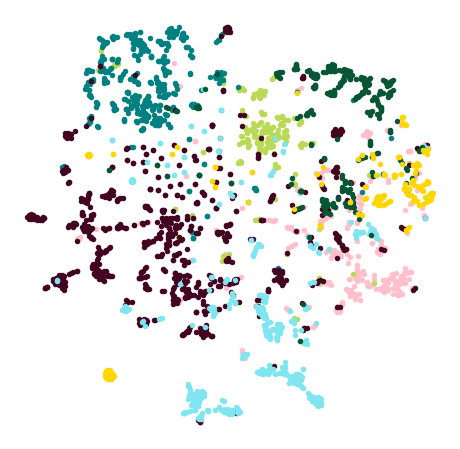

In [97]:
@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
    '#ffd700'
]
plot_points(colors)